In [651]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Adding a constant variable 
import statsmodels.api as sm  
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

# Supress Warnings

import warnings
warnings.filterwarnings('ignore')


In [652]:
##Block to define common function used through out

def univariate(df,col):
        sns.set(style="darkgrid")
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(10,3))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[1])
        plt.show()
        
# function to generate plots related to Categorical Variables
def categorical_plot(col,x,y):
    plt.figure(figsize = (x,y))
    plt.subplot(1,2,1)
    sns.barplot(col,'cnt',data=df)
    #plt.subplot(1,2,2)
   # sns.barplot(col,'cnt',data=df, hue='yr',palette='Paired')
    #plt.legend(labels=['2018', '2019'])
    return

# function to calculate VIF
def calulateVIF(X_train_new):
    vif = pd.DataFrame()
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif
        
# function to getStats model
def getStatModel(X_train_rfe,ytrain):
    X_train_rfe = sm.add_constant(X_train_rfe)
    lm = sm.OLS(ytrain,X_train_rfe).fit()   # Running the linear model
    return lm

# function to getStats model summary
def getStatModelSummary(X_train_rfe,ytrain):
    lm = getStatModel(X_train_rfe,ytrain)
    return lm.summary()

In [653]:
#import day.csv file
df = pd.read_csv('day.csv')

In [654]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [655]:
#Checking the shape of the dataframe 
df.shape

(730, 16)

### Steps:
1) Do Data cleaning  
2) Do exploratory Data anlysis -EDA  
2a) Convert numerical variables to categorical variables  
2b) Convert categorical variables to dummy variables  
3) Divide Dataset into test, train  
4) Sacling the variables  
5) Build Model - Remove features using RFE and then use statsmodel for manual removal of features  
6) Perform Residual analysis - Model evaluaton  
7) Make predictions  
8) Model Evaluation on test dataset  


### STEP 1: Data Cleaning

In [656]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [657]:
pd.isnull(df).sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [658]:
# How many types of each data type column exists
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
instant       730 non-null int64
dteday        730 non-null object
season        730 non-null int64
yr            730 non-null int64
mnth          730 non-null int64
holiday       730 non-null int64
weekday       730 non-null int64
workingday    730 non-null int64
weathersit    730 non-null int64
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.3+ KB


### Observation:

Except one column which is date type, all other are either float or integer type.
There are some fields that are categorical in nature, but are in integer/float type. Example : season, mnth, weathersit etc.
We will have to analyze and decide whether to convert them to categorical or treat as integer. 

### No null values hence no imputation required

### STEP2: Visualise the Data-EDA

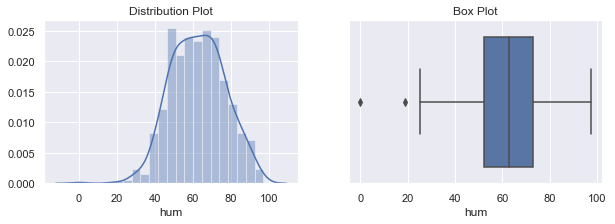

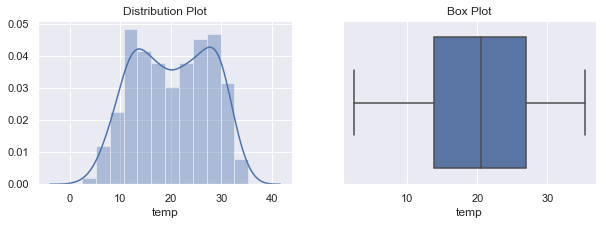

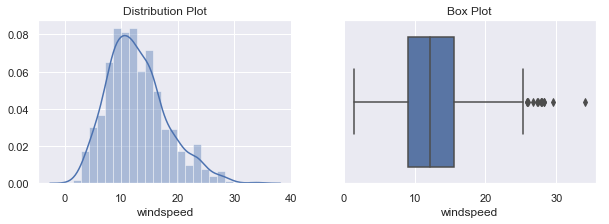

In [659]:
# Checking outliers in numeric columns using plots
univariate(df=df,col='hum')
univariate(df=df,col='temp')
univariate(df=df,col='windspeed')


### Observations: No major outliers

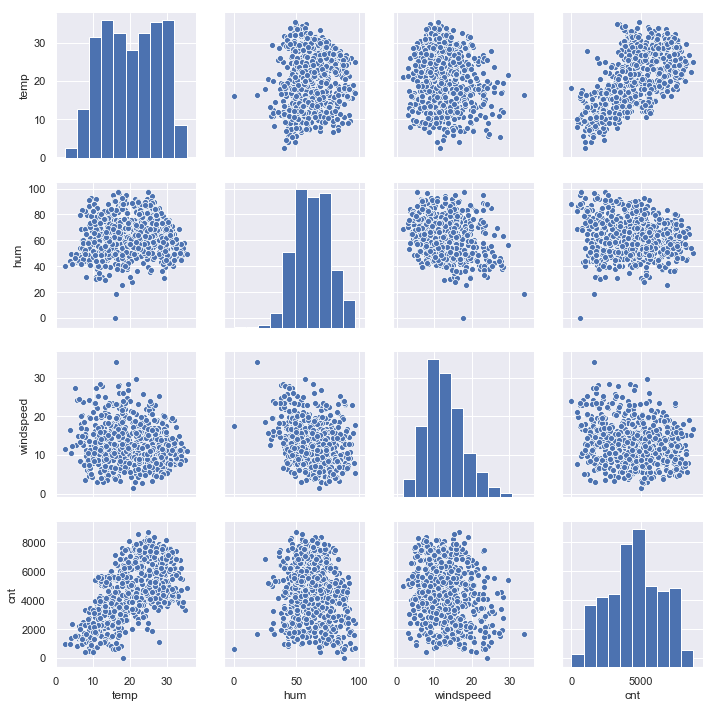

In [660]:
#Draw pair plots to see any co-relations between the variables to see which model is applicable
sns.pairplot(df[['temp','hum','windspeed','cnt']])
plt.show()

### Clearly from above plot temp and Cnt seems to have a linear relation

## Step2a  Convert numerical variables to categorical variables
Covert some numeric variables like 'weathersit' and 'season', mnth, weekday to categorical string values

In [661]:
#  maped weathersit column
df['weathersit']= df['weathersit'].map({1:'Clear',2:'Cloudy',3:'Snow',4:'Rain'})

#  maped season column
df['season']= df['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})

# maped mnth column values (1 to 12 ) as (jan to dec) respectively
df['mnth'] = df['mnth'].map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct',
                             11: 'nov', 12:'dec'})

# maped the weekday column according to descriptin
df['weekday'] = df['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

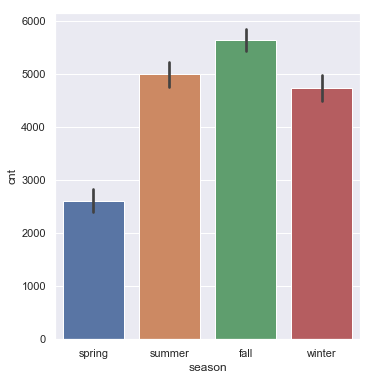

In [662]:
categorical_plot('season',12,6)

### Observations: In Fall season total bookings  are  higher.

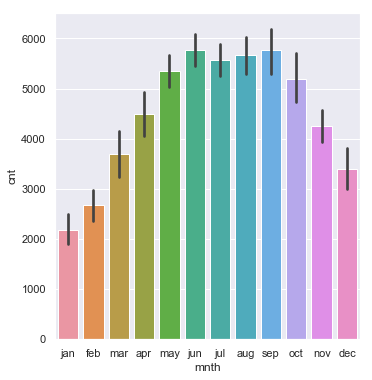

In [663]:
categorical_plot('mnth',12,6)

### Observations: In months from May-sept total renting is higher

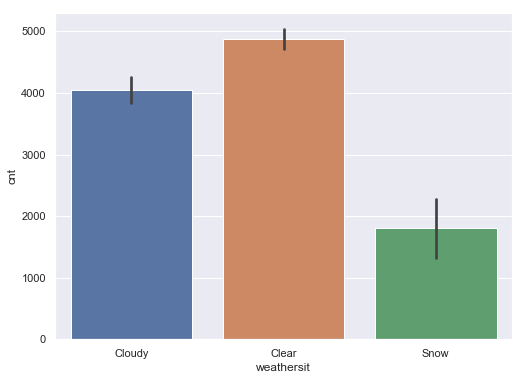

In [664]:
categorical_plot('weathersit',18,6)

### Observations: when weather is clear total bookings is higher.

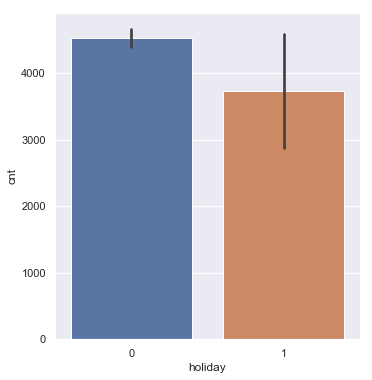

In [665]:
categorical_plot('holiday',12,6)

### Observations: On non holiday total bookings is higher Hence holiday is good variable for making prediction

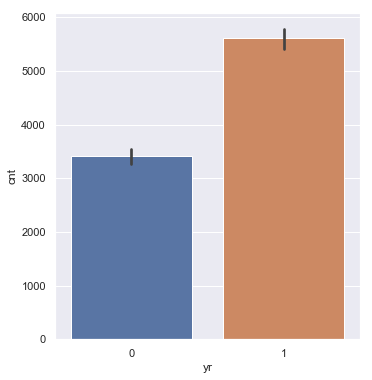

In [666]:
categorical_plot('yr',12,6)

### Observations: in 2019 total bookings is higher Hence yr is good variable for making prediction

### STep2b: Convert categorical variables to dummy variables

### The variable 'weathersit' and 'season' has four levels. We need to convert these levels into integer as well. For this, we will use something called dummy variables.

In [667]:
# Get the dummy variables for the feature weathersit' and store it in a new variable - 'status'
df=pd.get_dummies(data=df, columns=['season', 'mnth','yr','weekday','weathersit'], drop_first = True)
df.head()

,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
0,1,01-01-2018,0,0,14.110847,18.18125,80.5833,10.749882,331,654,...,0,0,0,1,0,0,0,0,1,0
1,2,02-01-2018,0,0,14.902598,17.68695,69.6087,16.652113,131,670,...,0,0,0,0,1,0,0,0,1,0
2,3,03-01-2018,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,...,0,0,0,0,0,0,1,0,0,0
4,5,05-01-2018,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,...,0,0,0,0,0,0,0,1,0,0


In [668]:
print(df.columns)
print(df.shape)


Index(['instant', 'dteday', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'season_spring',
       'season_summer', 'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov',
       'mnth_oct', 'mnth_sep', 'yr_1', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed',
       'weathersit_Cloudy', 'weathersit_Snow'],
      dtype='object')
(730, 34)


## STEP3: Splitting the dataset

In [669]:
# Splitting the data into Train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3, random_state=11)

In [670]:
print(Xtrain.columns)
print(Xtest.columns)
print(ytrain.head())

Index(['instant', 'dteday', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'season_spring',
       'season_summer', 'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov',
       'mnth_oct', 'mnth_sep', 'yr_1', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed',
       'weathersit_Cloudy', 'weathersit_Snow'],
      dtype='object')
Index(['instant', 'dteday', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'season_spring',
       'season_summer', 'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov',
       'mnth_oct', 'mnth_sep', 'yr_1', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed',
       'weathersit_Cloudy', 'weathersit_Snow'],
      dt

##  STEP4: Apply scaling to numeric variables

In [671]:
num_cols = ['temp','atemp','hum','windspeed','cnt']

In [672]:
std = MinMaxScaler()
Xtrain[num_cols] = std.fit_transform(Xtrain[num_cols])
Xtrain

,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
115,116,26-04-2018,0,1,0.699403,0.701405,0.749786,0.745868,678,3722,...,0,0,0,0,0,0,1,0,0,0
562,563,17-07-2019,0,1,0.943365,0.930276,0.520137,0.183152,921,5865,...,0,1,0,0,0,0,1,0,0,0
523,524,08-06-2019,0,1,0.722275,0.706757,0.481149,0.344890,1488,6248,...,0,1,0,0,0,0,0,0,0,0
524,525,09-06-2019,0,0,0.802869,0.778287,0.449443,0.262379,2708,4790,...,0,1,0,1,0,0,0,0,0,0
268,269,26-09-2018,0,1,0.722275,0.694266,0.872322,0.173258,684,3946,...,1,0,1,0,0,0,0,0,1,0
499,500,15-05-2019,0,1,0.673265,0.676367,0.817052,0.270617,625,4490,...,0,1,0,0,0,0,1,0,1,0
198,199,18-07-2018,0,1,0.849702,0.856972,0.669666,0.452144,841,3617,...,0,0,1,0,0,0,0,0,0,0
584,585,08-08-2019,0,1,0.854058,0.862343,0.691946,0.173258,1263,6271,...,0,1,0,0,0,0,0,1,1,0
409,410,14-02-2019,0,1,0.290984,0.332978,0.523136,0.254132,135,3787,...,0,1,0,0,0,0,1,0,1,0
661,662,24-10-2019,0,1,0.641680,0.651323,0.654242,0.072638,795,6898,...,0,1,0,0,0,0,0,1,0,0


In [673]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)
print(ytrain.head())
ytrain = Xtrain.pop('cnt')
print(ytrain.head())

(511, 34)
(219, 34)
(511,)
(219,)
115    4400
562    6786
523    7736
524    7498
268    4630
Name: cnt, dtype: int64
115    0.478545
562    0.766953
523    0.881784
524    0.853016
268    0.506346
Name: cnt, dtype: float64


In [674]:
#drop dteDay Since dteDay is covered under yr
df = df.drop('dteday',axis = 1)
Xtrain = Xtrain.drop('dteday',axis = 1)

#Drop instant since this is auto-increment number, will not have any significance in model
df = df.drop('instant',axis = 1)
Xtrain = Xtrain.drop('instant',axis = 1)

#Drop instant since this already connected to cnt, will be directly corelated to Cnt
df = df.drop('registered',axis = 1)
Xtrain = Xtrain.drop('registered',axis = 1)

#Drop instant since this already connected to cnt,  will be directly corelated to Cnt
df = df.drop('casual',axis = 1)
Xtrain = Xtrain.drop('casual',axis = 1)


In [675]:
df.head()


,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [676]:
df.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849,0.246575,0.252055,0.243836,...,0.082192,0.500000,0.143836,0.143836,0.143836,0.142466,0.142466,0.141096,0.336986,0.028767
std,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647,0.431313,0.434490,0.429689,...,0.274845,0.500343,0.351164,0.351164,0.351164,0.349767,0.349767,0.348359,0.473004,0.167266
min,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [677]:
print(df.dtypes)

holiday                int64
workingday             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
cnt                    int64
season_spring          uint8
season_summer          uint8
season_winter          uint8
mnth_aug               uint8
mnth_dec               uint8
mnth_feb               uint8
mnth_jan               uint8
mnth_jul               uint8
mnth_jun               uint8
mnth_mar               uint8
mnth_may               uint8
mnth_nov               uint8
mnth_oct               uint8
mnth_sep               uint8
yr_1                   uint8
weekday_Mon            uint8
weekday_Sat            uint8
weekday_Sun            uint8
weekday_Thu            uint8
weekday_Tue            uint8
weekday_Wed            uint8
weathersit_Cloudy      uint8
weathersit_Snow        uint8
dtype: object


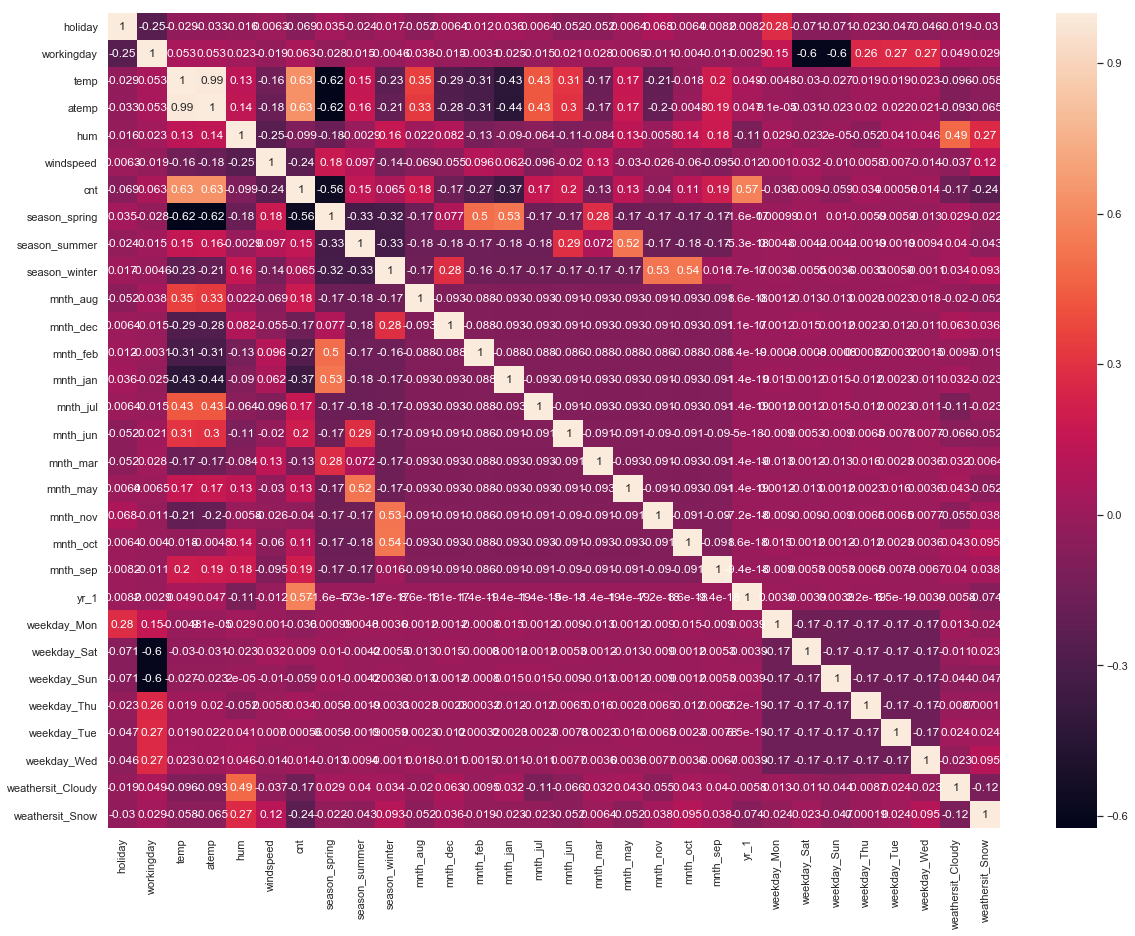

In [678]:
corrMatrix = df.corr()
plt.figure(figsize = (20, 15))
sns.heatmap(corrMatrix, annot=True)
#sns.set(rc={"figure.figsize":(100, 50)}) #width=20, #height=20
plt.show()

### Observation: Clearly from co-relation matrix temp and atemp are directly corelated so we can safely drop one of them as well as spring, summer, winter is directly coreleated to temp as corelation score  is  > 0.5

temp and CNt are highly corelated

You can see a corelation between month and seasons like May is to Summer and Spring is to Feb and Jan

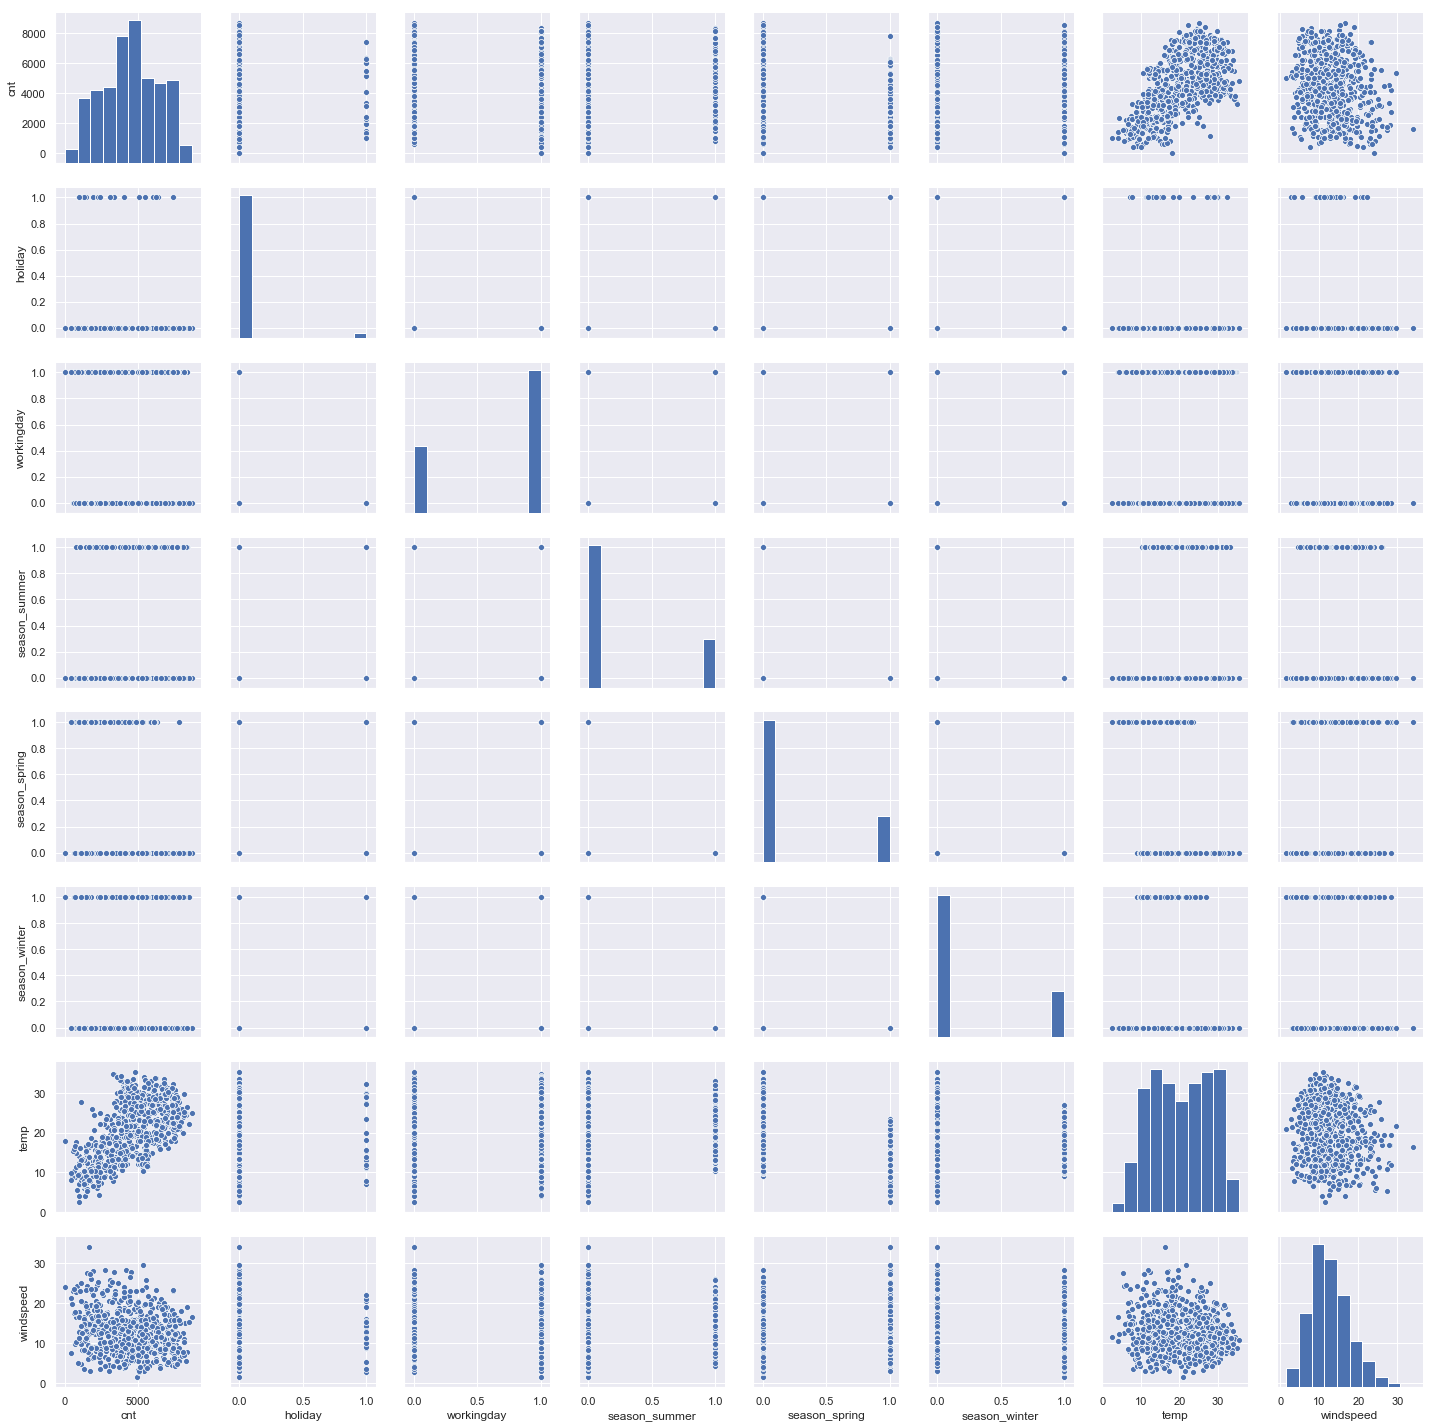

In [679]:
# Create pairplot of all the variables that are correlated from above matrix, lets' remove non colrelated variables to cnt using model
#sns.pairplot(df)  
sns.pairplot(df,vars=['cnt','holiday','workingday','season_summer','season_spring','season_winter','temp','windspeed'])  
plt.show()

### Clear linear coreleation is visible between cnt and temp

### STEP5: Building our model
This time, we will be using the LinearRegression function from SciKit Learn for its compatibility with RFE (which is a utility from sklearn)

Perform RFE to remove features and then follow manual removal using statsmodel 
Recursive feature elimination

In [680]:
print(Xtest.columns)
#ytrain = Xtrain['cnt']
#X= df
#Xtrain = Xtrain.pop('cnt')

Index(['instant', 'dteday', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'season_spring',
       'season_summer', 'season_winter', 'mnth_aug', 'mnth_dec', 'mnth_feb',
       'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar', 'mnth_may', 'mnth_nov',
       'mnth_oct', 'mnth_sep', 'yr_1', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed',
       'weathersit_Cloudy', 'weathersit_Snow'],
      dtype='object')


In [681]:
###### Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(Xtrain, ytrain)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(Xtrain, ytrain)

In [682]:
list(zip(Xtrain.columns,rfe.support_,rfe.ranking_))

[('holiday', False, 4),
 ('workingday', False, 2),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 10),
 ('season_winter', True, 1),
 ('mnth_aug', False, 13),
 ('mnth_dec', True, 1),
 ('mnth_feb', True, 1),
 ('mnth_jan', True, 1),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 9),
 ('mnth_mar', False, 12),
 ('mnth_may', False, 7),
 ('mnth_nov', True, 1),
 ('mnth_oct', False, 6),
 ('mnth_sep', False, 3),
 ('yr_1', True, 1),
 ('weekday_Mon', False, 8),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', False, 5),
 ('weekday_Thu', False, 15),
 ('weekday_Tue', False, 11),
 ('weekday_Wed', False, 14),
 ('weathersit_Cloudy', True, 1),
 ('weathersit_Snow', True, 1)]

In [683]:
col = Xtrain.columns[rfe.support_]
col

Index(['temp', 'atemp', 'hum', 'windspeed', 'season_spring', 'season_winter',
       'mnth_dec', 'mnth_feb', 'mnth_jan', 'mnth_jul', 'mnth_nov', 'yr_1',
       'weekday_Sat', 'weathersit_Cloudy', 'weathersit_Snow'],
      dtype='object')

## Building model using statsmodel, for the detailed statistics

In [684]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = Xtrain[col]

In [685]:
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     186.6
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          1.36e-192
Time:                        12:00:21   Log-Likelihood:                 496.96
No. Observations:                 511   AIC:                            -961.9
Df Residuals:                     495   BIC:                            -894.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3681      0.03

In [686]:
#lets drop column atemp       since it has very high P value i.e. > 0.05 significance level, anyways from correlation matrix we found temp and atemp were correlated
X_train_rfe = X_train_rfe.drop(["atemp"], axis = 1)
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     200.0
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          1.35e-193
Time:                        12:00:21   Log-Likelihood:                 496.59
No. Observations:                 511   AIC:                            -963.2
Df Residuals:                     496   BIC:                            -899.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3726      0.03

### Observation: There are no p value greater than 0.05 but there are still some columns where VIF is > 5 let's drop those to simplify our model

In [687]:
#lets drop column hum since it has very VIF i.e. > 5
X_train_rfe = X_train_rfe.drop(["hum"], axis = 1)
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.9
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          8.60e-192
Time:                        12:00:21   Log-Likelihood:                 489.51
No. Observations:                 511   AIC:                            -951.0
Df Residuals:                     497   BIC:                            -891.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2934      0.02

### Observation Adjusted R-square is decreasing which is not good but we can still drop VIF > 5 to simplify the model further but we have already seen temp if correlated to Cnt hence let's not drop it.

In [688]:
X_train_rfe.columns

Index(['temp', 'windspeed', 'season_spring', 'season_winter', 'mnth_dec',
       'mnth_feb', 'mnth_jan', 'mnth_jul', 'mnth_nov', 'yr_1', 'weekday_Sat',
       'weathersit_Cloudy', 'weathersit_Snow'],
      dtype='object')

In [689]:
print(getStatModelSummary(X_train_rfe,ytrain))
print(calulateVIF(X_train_rfe))
# X_train_rfe = X_train_rfe.drop(["const"], axis = 1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.9
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          8.60e-192
Time:                        12:00:21   Log-Likelihood:                 489.51
No. Observations:                 511   AIC:                            -951.0
Df Residuals:                     497   BIC:                            -891.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2934      0.02

In [690]:
# Checking the parameters obtained
lm= getStatModel(X_train_rfe,ytrain)
lm.params

const                0.293426
temp                 0.360252
windspeed           -0.114046
season_spring       -0.096127
season_winter        0.079929
mnth_dec            -0.100545
mnth_feb            -0.074138
mnth_jan            -0.100478
mnth_jul            -0.066659
mnth_nov            -0.104161
yr_1                 0.256542
weekday_Sat          0.028241
weathersit_Cloudy   -0.075520
weathersit_Snow     -0.264098
dtype: float64

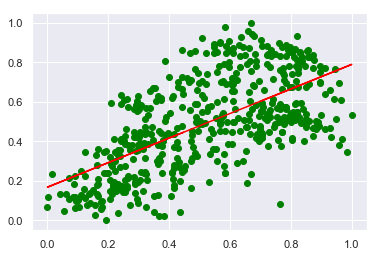

In [691]:
##ploting the results of temp vs cnt to see how much linear regression model is followed
plt.plot(Xtrain.temp, ytrain, 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(Xtrain.temp, ytrain, 1)

#use red as color for regression line
plt.plot(Xtrain.temp, m*Xtrain.temp+b, color='red')

### Seems model is prepared as probablity is < 0.05 and VIF are not > 5(Exception of temp)

### STEP6: Residual Analysis of the train data
So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [692]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.9
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          8.60e-192
Time:                        12:00:21   Log-Likelihood:                 489.51
No. Observations:                 511   AIC:                            -951.0
Df Residuals:                     497   BIC:                            -891.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2934      0.026     11.500      0.000       0.243       0.344
temp                  0.3603      0.033     10.993      0.000       0.296       0.425
windspeed            -0.1140      0.022     -5.295      0.000      -0.156      -0.072
season_spring        -0.0961      0.018     -5.253      0.000      -0.132      -0.060
season_winter         0.0799      0.015      5.504      0.000       0.051       0.108
mnth_dec             -0.1005      0.019     -5.318      0.000      -0.138      -0.063
mnth_feb             -0.0741      0.022     -3.385      0.001      -0.117      -0.031
mnth_jan             -0.1005      0.023     -4.436      0.000      -0.145      -0.056
mnth_jul             -0.0667      0.017     -3.810      0.000      -0.101      -0.032
mnth_nov             -0.1042      0.020     -5.241      0.000      -0.143      -0.065
yr_1                  0.2565      0.008     30.374      0.000       0.240       0.273
weekday_Sat           0.0282      0.012      2.409      0.016       0.005       0.051
weathersit_Cloudy    -0.0755      0.009     -8.409      0.000      -0.093      -0.058
weathersit_Snow      -0.2641      0.029     -9.013      0.000      -0.322      -0.207
==============================================================================
Omnibus:                       63.523   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.800
Skew:                          -0.717   Prob(JB):                     4.82e-28
Kurtosis:                       4.962   Cond. No.                         15.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [693]:
#X_train_error =X_train_rfe 
#X_train_error = sm.add_constant(X_train_error)
#lm = sm.OLS(ytrain,X_train_error).fit()   # Running the linear model
#print(X_train_error.shape)
ytrain_pred=getStatModel(X_train_error,ytrain).predict(X_train_error)

Text(0.5, 0, 'Errors')

<Figure size 432x288 with 0 Axes>

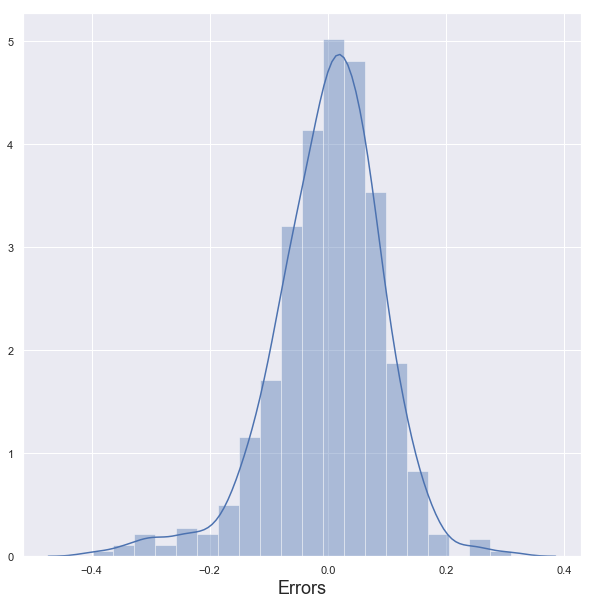

In [694]:
# Plot the histogram of the error terms
fig = plt.figure()
plt.figure(figsize = (10, 10))
sns.distplot((ytrain - ytrain_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label"

### STEP7: Making Predictions
Applying the scaling on the test sets

In [695]:
Xtest.head()

,instant,dteday,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_sep,yr_1,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Snow
667,668,30-10-2019,0,1,13.045462,15.49545,82.5455,14.271603,87,1009,...,0,1,0,0,0,0,1,0,1,0
541,542,26-06-2019,0,1,25.864153,29.73520,37.3333,23.292014,1077,6365,...,0,1,0,0,0,0,1,0,0,0
429,430,06-03-2019,0,1,10.591653,12.75210,45.6667,13.458625,221,3735,...,0,1,0,0,0,0,1,0,0,0
150,151,31-05-2018,0,1,31.775000,36.26915,63.6667,7.459043,673,3309,...,0,0,0,0,0,0,1,0,0,0
296,297,24-10-2018,0,1,18.996653,22.85335,77.2083,7.959064,699,3488,...,0,0,1,0,0,0,0,0,0,0


In [696]:
#apply scaling on test data
#num_cols = ['temp','atemp','hum','windspeed','cnt']
#std = MinMaxScaler()
Xtest[num_cols] = std.transform(Xtest[num_cols])
Xtest.head()
ytest = Xtest.pop('cnt')

#ytest = Xtest.pop('cnt')

In [697]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
Xtest_new = Xtest[X_train_rfe.columns]

# Adding a constant variable 
Xtest_new = sm.add_constant(Xtest_new)

In [698]:
# Making predictions
ytest_pred = lm.predict(Xtest_new)

### STEP 8: Model Evaluation

### Hypothesis Testing :
Hypothesis Testing States that
H0:B1=B2=...=Bn=0
H1: at least one Bi!=0

lm model coefficient values

const                0.293426
temp                 0.360252
windspeed           -0.114046
season_spring       -0.096127
season_winter        0.079929
mnth_dec            -0.100545
mnth_feb            -0.074138
mnth_jan            -0.100478
mnth_jul            -0.066659
mnth_nov            -0.104161
yr_1                 0.256542
weekday_Sat          0.028241
weathersit_Cloudy   -0.075520
weathersit_Snow     -0.264098
dtype: float64

### Observations: From the lm model summary, it is evident that all our coefficients are not equal to zero, which means we REJECT the NULL HYPOTHESIS

Text(0, 0.5, 'ypred')

<Figure size 432x288 with 0 Axes>

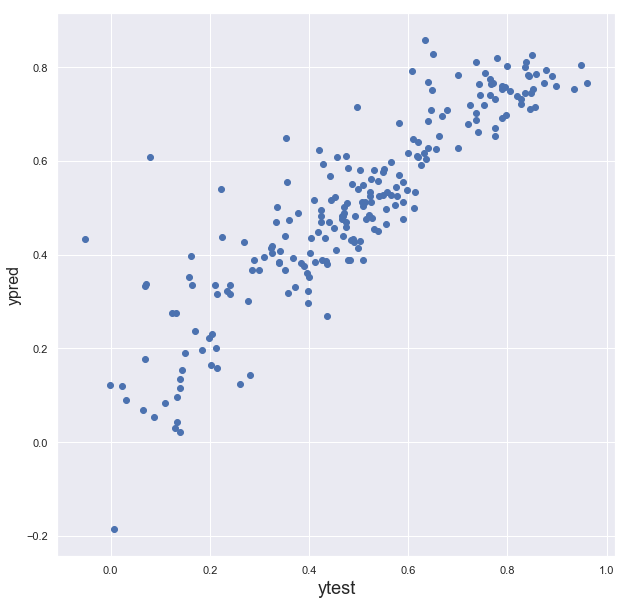

In [699]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize = (10, 10))
plt.scatter(ytest,ytest_pred)
fig.suptitle('ytest vs ypred', fontsize=20)              # Plot heading 
plt.xlabel('ytest', fontsize=18)                          # X-label
plt.ylabel('ypred', fontsize=16)                          # Y-label

### Observation:ytest vs ypred plot is quite linear

In [703]:
from sklearn.metrics import r2_score
print('Train R-Score: ' ,r2_score(ytrain,ytrain_pred))  # R score for train data
print('Test R-Score: ' ,r2_score(ytest, ytest_pred))

r2_score(ytest, ypred)

Train R-Score:  0.8453001522549157
Test R-Score:  0.7889339250418007


0.7735460642217353

In [701]:
X_train_rfe.columns

Index(['temp', 'windspeed', 'season_spring', 'season_winter', 'mnth_dec',
       'mnth_feb', 'mnth_jan', 'mnth_jul', 'mnth_nov', 'yr_1', 'weekday_Sat',
       'weathersit_Cloudy', 'weathersit_Snow'],
      dtype='object')

In [702]:
lm.params

const                0.293426
temp                 0.360252
windspeed           -0.114046
season_spring       -0.096127
season_winter        0.079929
mnth_dec            -0.100545
mnth_feb            -0.074138
mnth_jan            -0.100478
mnth_jul            -0.066659
mnth_nov            -0.104161
yr_1                 0.256542
weekday_Sat          0.028241
weathersit_Cloudy   -0.075520
weathersit_Snow     -0.264098
dtype: float64

### FINAL Equation:
The equation of best fitted surface based on model lm:
cnt=0.293426 + (0.360252 x temp) + (-0.114046 x windspeed) + (-0.096127 x season_spring) + (0.079929 x season_winter) + (-0.100545 x mnth_dec) + (-0.074138 x mnth_feb) + (-0.100478 x mnth_jan) + (-0.066659 x mnth_jul) + (-0.104161 x mnth_nov)  + ( 0.256542 x yr_1) + ( 0.028241  x weekday_Sat) + ( -0.075520  x weathersit_Cloudy) + ( -0.264098  x weathersit_Snow)
    

### Observations: 
Significant variables to predict the demand for shared bikes are  'temp', 'windspeed', 'season_spring--season', 'season_winter--season',
       'mnth_dec---month', 'mnth_jul --month', 'mnth_nov --month', 'yr_1---year(2019)', 'weekday_Sat --weekday',
       'weathersit_Snow--weathersit','weathersit_CLoudy--weathersit'